In [2]:
!tar -xvzf en_core_web_sm-3.4.0.tar.gz

tar (child): en_core_web_sm-3.4.0.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [1]:
import pandas as pd

In [2]:
df_mt = pd.read_csv("/ssd003/projects/pets/datasets/mtsamples.csv")

df_mt_X = df_mt[["description",'sample_name', 'transcription', 'keywords']]
df_mt_Y = df_mt["medical_specialty"]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_mt_X, df_mt_Y, test_size=0.2, random_state=42)

In [6]:
X_train.describe()

,description,sample_name,transcription,keywords
count,3999,3999,3973,3145
unique,2239,2265,2246,3079
top,An example/template for a routine normal male...,Thyroid Mass Consult,"CHIEF COMPLAINT: , Jaw pain.,HISTORY OF PRESEN...",
freq,10,4,4,65


In [7]:
y_train.groupby(y_train).count().sort_values(ascending=False)

medical_specialty
 Surgery                          872
 Consult - History and Phy.       409
 Cardiovascular / Pulmonary       303
 Orthopedic                       287
 General Medicine                 209
 Radiology                        205
 Gastroenterology                 188
 Neurology                        179
 SOAP / Chart / Progress Notes    139
 Obstetrics / Gynecology          125
 Urology                          121
 Discharge Summary                 87
 Neurosurgery                      76
 Hematology - Oncology             75
 ENT - Otolaryngology              73
 Nephrology                        66
 Ophthalmology                     65
 Emergency Room Reports            58
 Pediatrics - Neonatal             55
 Pain Management                   53
 Psychiatry / Psychology           46
 Podiatry                          42
 Office Notes                      40
 Dermatology                       26
 Cosmetic / Plastic Surgery        23
 Letters                        

In [8]:
import spacy

In [22]:
idx=1341     
df_mt_Y.iloc[idx], df_mt_X["transcription"].iloc[idx]

(' SOAP / Chart / Progress Notes',
 "REASON FOR VISIT:,  Followup visit status post removal of external fixator and status post open reduction internal fixation of right tibial plateau fracture.,HISTORY OF PRESENT ILLNESS: , The patient is now approximately week status post removal of Ex-Fix from the right knee with an MUA following open reduction internal fixation of right tibial plateau fracture.  The patient states that this pain is well controlled.  He has had no fevers, chills or night sweats.  He has had some mild drainage from his pin sites.  He just started doing range of motion type exercises for his right knee.  He has had no numbness or tingling.,FINDINGS: , On exam, his pin sites had no erythema.  There is some mild drainage but they have been dressing with bacitracin, it looks like there may be part of the fluid noted.  The patient had 3/5 strength in the EHL, FHL.  He has intact sensation to light touch in a DP, SP, and tibial nerve distribution.,X-rays taken include thre

In [10]:
nlp = spacy.load("../en_core_web_sm-3.4.0/en_core_web_sm/en_core_web_sm-3.4.0/", 
                 disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])

In [11]:
y_train.iloc[0]

' Radiology'

In [12]:
doc = nlp(X_train["transcription"].iloc[0])

In [13]:
# from collections import Counter
# vocab = Counter()

# def compile_vocab(s):
#     vocab.update(Counter([t.text for t in nlp(s.lower())]))
# X_train[~X_train["transcription"].isna()]["transcription"].apply(compile_vocab)
# len(vocab)

In [14]:
import string
with open("../stopwords/english") as fin:
    stopwords = {l.strip() for l in fin}
    
# for s in stopwords:
#     vocab.pop(s, None)
    
# for c in string.punctuation:
#     vocab.pop(c, None)
    
# vocab.pop(' ', None)

# len(vocab)

In [15]:
# with open("./vocab_all.txt", "w", encoding="utf-8") as fout:
#     for k,c in vocab.items():
#         fout.write(f"{k}:{c}\n")

In [16]:
# from collections import Counter
# vocab = Counter()

# with open("./vocab_all.txt", encoding="utf-8") as fin:
#     for l in fin:
#         vv = l.split(':')
#         w = ':'.join(vv[:-1])
#         c = int(vv[-1])
#         vocab[w]= c

In [17]:
glove = {}
with open("../glove.6B.100d.txt", encoding="utf-8") as fin:
    for l in fin:
        vv = l.split(' ')
        v = list(map(float, vv[-100:]))
        w = ' '.join(vv[:-100])
        glove[w]=v

In [18]:
# vocab1000 = vocab.most_common(1000)
# vocab1000 = {v[0]:i for i,v in enumerate(vocab1000)}

In [19]:
import numpy as np

def word_vector(s):
    embedding = np.zeros(100)
    if not pd.isna(s):
        v = [glove[t.text] for t in nlp(s.lower()) 
                 if (t.text in glove and 
                     t.text not in stopwords and 
                     t.text not in string.punctuation)]
        embedding = np.array(v).mean(axis=0)
    return embedding

X = np.stack(X_train["transcription"].apply(word_vector))

In [20]:
X.shape

(3999, 100)

In [21]:
label_counts = y_train.groupby(y_train).count()

In [22]:
lbl = pd.Series(y_train.groupby(y_train).count().sort_values(ascending=False).index)

In [23]:
def f(v):
    if label_counts[v]>100:
        return lbl[lbl==v].index[0]
    else:
        return 11

Y = y_train.apply(f).to_numpy()

In [24]:
Y.shape

(3999,)

In [25]:
import torch

In [26]:
class MLR(torch.nn.Module):

    def __init__(self, n_features, n_classes):
        super(MLR, self).__init__()
        self.lr = torch.nn.Linear(n_features, n_classes)
        
    def forward(self, x):
        out = torch.special.log_softmax(self.lr(x), 0)
        return out

In [27]:
model = MLR(X.shape[1], max(Y)+1)

optim = torch.optim.SGD(model.parameters(), lr=1)
# use Binary Cross Entropy Loss
criterion = torch.nn.NLLLoss()

In [28]:
x_train_tensor = torch.from_numpy(X).float()
y_train_tensor = torch.from_numpy(Y).long()

In [29]:
EPOCHS = 10000

def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        if e%1000==0:
            acc = torch.argmax(model.forward(x_train_tensor), axis=1)==y_train_tensor
            print(f"Loss at epoch {e}: {loss.data}, correct predicted: {np.sum(acc.numpy())}")
            
    return model

model = train(model, optim, criterion, x_train_tensor, y_train_tensor)

Loss at epoch 1000: 7.665160655975342, correct predicted: 1464
Loss at epoch 2000: 7.595707893371582, correct predicted: 1495
Loss at epoch 3000: 7.561037540435791, correct predicted: 1512
Loss at epoch 4000: 7.5389862060546875, correct predicted: 1540
Loss at epoch 5000: 7.523374080657959, correct predicted: 1561
Loss at epoch 6000: 7.511655330657959, correct predicted: 1577
Loss at epoch 7000: 7.50251579284668, correct predicted: 1572
Loss at epoch 8000: 7.4951863288879395, correct predicted: 1573
Loss at epoch 9000: 7.48917818069458, correct predicted: 1576
Loss at epoch 10000: 7.484161376953125, correct predicted: 1579


In [30]:
X_test2 = np.stack(X_test["transcription"].apply(word_vector))
Y_test2 = y_test.apply(f).to_numpy()

In [31]:
x_test_tensor = torch.from_numpy(X_test2).float()
y_test_tensor = torch.from_numpy(Y_test2).long()

In [32]:
acc = torch.argmax(model.forward(x_test_tensor), axis=1)==y_test_tensor
np.sum(acc.numpy())

330

In [33]:
x_test_tensor.shape

torch.Size([1000, 100])

In [34]:
import tenseal as ts
poly_mod_degree = 4096
coeff_mod_bit_sizes = [40, 20, 40]
# create TenSEALContext
ctx_eval = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
# scale of ciphertext to use
ctx_eval.global_scale = 2 ** 20
# this key is needed for doing dot-product operations
ctx_eval.generate_galois_keys()

In [29]:
class EncryptedLR:
    
    def __init__(self, torch_lr):
        # TenSEAL processes lists and not torch tensors,
        # so we take out the parameters from the PyTorch model
        self.weight = np.array(torch_lr.lr.weight.data.tolist()).T
        self.bias = np.array(torch_lr.lr.bias.data.tolist())[np.newaxis,:]
        
    def forward(self, enc_x):
        # We don't need to perform sigmoid as this model
        # will only be used for evaluation, and the label
        # can be deduced without applying sigmoid
        enc_out = enc_x.mm(self.weight) + self.bias
        return enc_out
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    ################################################
    ## You can use the functions below to perform ##
    ## the evaluation with an encrypted model     ##
    ################################################
    
    def encrypt(self, context):
        self.weight = ts.ckks_tensor(context, self.weight)
        self.bias = ts.ckks_tensor(context, self.bias)
        
    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()
        

model_enc = EncryptedLR(model)
model_enc.encrypt(ctx_eval)

In [33]:
%%time
enc_x_0 = ts.ckks_tensor(ctx_eval, X[:100])  100*100

CPU times: user 39.4 s, sys: 1.42 s, total: 40.8 s
Wall time: 11.2 s


In [34]:
%%time
out=model_enc.forward(enc_x_0)  100*100 * 100* 12 + 12

CPU times: user 6min 31s, sys: 4.19 s, total: 6min 36s
Wall time: 1min 40s


In [36]:
out2= np.array(out.decrypt().tolist())

In [40]:
loss = criterion(torch.from_numpy(out2).float(), y_train_tensor[:100])
loss.data

tensor(-1.0981)

In [42]:
out = model.forward(x_train_tensor[:100])
loss = criterion(out, y_train_tensor[:100])
loss.data

tensor(3.8953)

In [49]:
out[0]

torch.Size([100, 12])

In [48]:
out2.shape

(100, 12)

In [36]:
W = np.array(model.lr.weight.data.tolist()).T
enc_W= ts.ckks_tensor(ctx_eval, W)

bias = np.array(model.lr.bias.data.tolist())
enc_bias = ts.ckks_tensor(ctx_eval, bias[np.newaxis,:])

In [37]:
for c in range(1, 6):
    aa = np.matmul(X[0:c], W) + bias
    enc_X = ts.ckks_tensor(ctx_eval, X[:c])
    bb = np.array((enc_X.mm(enc_W) + enc_bias).decrypt().tolist())
    print(np.sum(np.abs(aa-bb)))

0.2918665627214959
0.49005764091122384
1.0302256807573742
1.3749713208072287
1.6207503361904692


In [51]:
a  = pd.DataFrame(data={'x':[1,2,3,4,5],'y':[0.2918665627214959,
0.49005764091122384,
1.0302256807573742,
1.3749713208072287,
1.620750336190469]})



In [52]:
a

,x,y
0,1,0.291867
1,2,0.490058
2,3,1.030226
3,4,1.374971
4,5,1.620750


<AxesSubplot:xlabel='x', ylabel='y'>

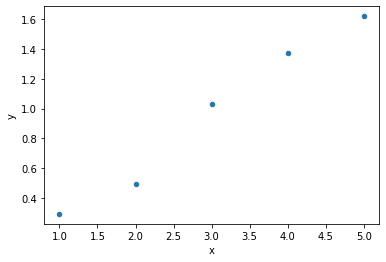

In [53]:
a.plot(kind="scatter", x="x", y="y")